In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("debashishsau/aslamerican-sign-language-aplhabet-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.20G/4.20G [02:25<00:00, 30.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset/versions/1


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

directory = '/root/.cache/kagglehub/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset/versions/1/ASL_Alphabet_Dataset/asl_alphabet_train'

image_size = 64
batch_size = 32

train_ds = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    subset="training",
    shuffle=True,
    seed=42
)

temp_ds = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    seed=42
)

temp_size = tf.data.experimental.cardinality(temp_ds).numpy()
valid_size = temp_size // 2

valid_ds = temp_ds.take(valid_size)
test_ds  = temp_ds.skip(valid_size)

Found 223074 files belonging to 29 classes.
Using 178460 files for training.
Found 223074 files belonging to 29 classes.
Using 44614 files for validation.


In [8]:
class_names = train_ds.class_names
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [14]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
for image_batch, label_batch in train_ds.take(1):
    print(f"Batch Shape {image_batch.shape}")
    print(f"Image Shape {image_batch[0].shape}")
    print(f"Label Shape {label_batch[0].shape}")

Batch Shape (32, 64, 64, 3)
Image Shape (64, 64, 3)
Label Shape ()


In [9]:
train_ds_scaled = train_ds.map(lambda x, y: (x/255.0, y))
valid_ds_scaled   = valid_ds.map(lambda x, y: (x/255.0, y))
test_ds_scaled   = test_ds.map(lambda x, y: (x/255.0, y))

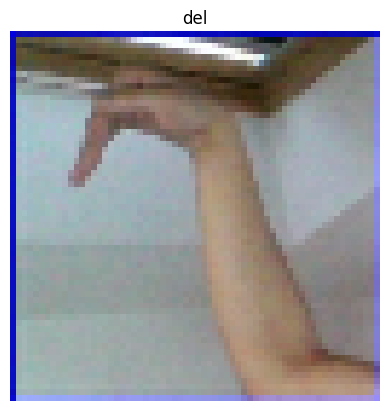

In [19]:
import matplotlib.pyplot as plt

def plot_image(img,label):
    img = tf.reshape(img, (image_size,image_size, 3))
    img = tf.cast(img, dtype=tf.uint8)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')
    plt.show()

image_index = 2
plot_image(image_batch[image_index],label_batch[image_index])

In [20]:
# Scale the image by divide it by 255 (Normalization)
train_ds_scaled = train_ds.map(lambda x, y: (x/255.0, y))
valid_ds_scaled   = valid_ds.map(lambda x, y: (x/255.0, y))
test_ds_scaled   = test_ds.map(lambda x, y: (x/255.0, y))

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,819,549 (18.39 MB)

 Trainable params: 4,819,549 (18.39 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(train_ds,validation_data=valid_ds,epochs=2)

Epoch 1/2
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 1616s 289ms/step - accuracy: 0.4039 - loss: 2.5520 - val_accuracy: 0.9188 - val_loss: 0.2950
Epoch 2/2
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 1572s 282ms/step - accuracy: 0.8545 - loss: 0.4882 - val_accuracy: 0.9486 - val_loss: 0.1831


In [28]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

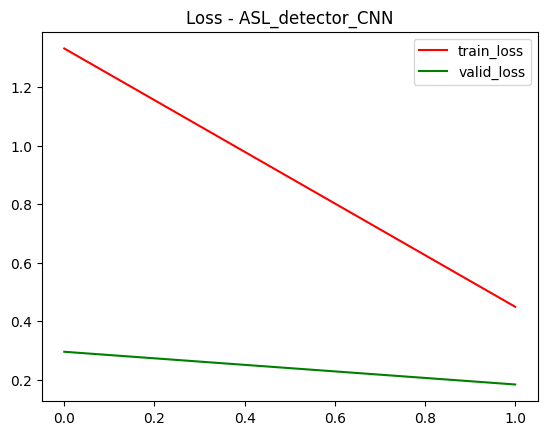

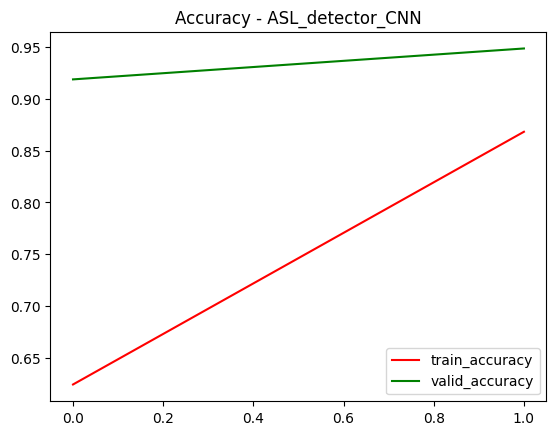

In [32]:
def plot_loss_acc(history, model_name='model_1'):
    plt.title(f"Loss - {model_name}")
    plt.plot(history.history['loss'], c='red', label='train_loss')
    plt.plot(history.history['val_loss'], c='green', label='valid_loss')
    plt.legend()
    plt.show()

    plt.title(f"Accuracy - {model_name}")
    plt.plot(history.history['accuracy'], c='red', label='train_accuracy')
    plt.plot(history.history['val_accuracy'], c='green', label='valid_accuracy')
    plt.legend()
    plt.show()

plot_loss_acc(history, model_name='ASL_detector_CNN')

In [31]:
model.evaluate(test_ds)

698/698 ━━━━━━━━━━━━━━━━━━━━ 80s 94ms/step - accuracy: 0.9435 - loss: 0.2054


[0.19476474821567535, 0.9451815485954285]

In [35]:
# load test images
import os
folder = "/root/.cache/kagglehub/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset/versions/1/ASL_Alphabet_Dataset/asl_alphabet_test"

test_images = []
test_labels = []

for filename in os.listdir(folder):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(folder, filename)

        # 1. Load image and resize
        img = tf.keras.utils.load_img(img_path, target_size=(image_size,image_size))
        img_array = tf.keras.utils.img_to_array(img)
        test_images.append(img_array)

        # 2. Label from filename (without extension)
        label = os.path.splitext(filename)[0]
        test_labels.append(label)

# Convert to tensors
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)   # shape: (29, 64, 64, 3)

print("Images shape:", test_images.shape)
print("Labels:", test_labels)

Images shape: (28, 64, 64, 3)
Labels: ['F_test', 'D_test', 'S_test', 'V_test', 'T_test', 'C_test', 'K_test', 'A_test', 'nothing_test', 'L_test', 'U_test', 'O_test', 'space_test', 'E_test', 'Y_test', 'X_test', 'B_test', 'Q_test', 'N_test', 'G_test', 'P_test', 'M_test', 'R_test', 'J_test', 'Z_test', 'W_test', 'I_test', 'H_test']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


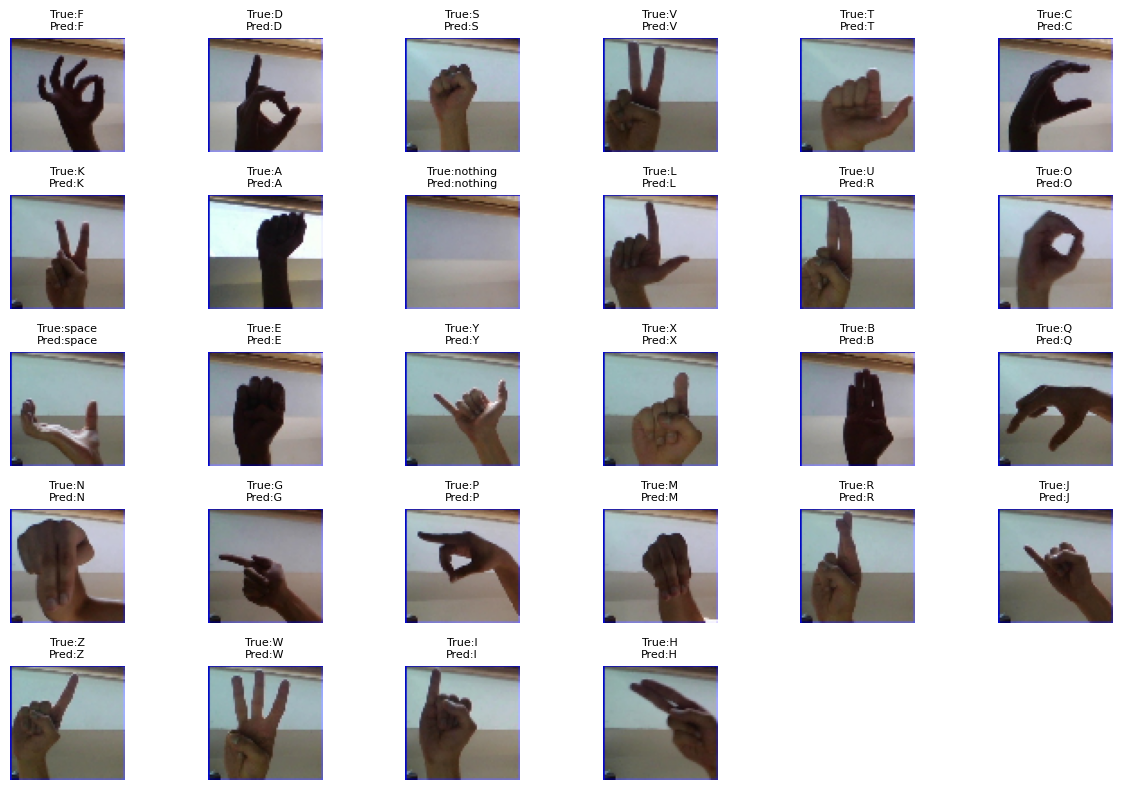

In [36]:
pred_propas = model.predict(test_images)
pred_labels = pred_propas.argmax(axis=-1)

plt.figure(figsize=(12, 8))

for i in range(len(test_images)):
    plt.subplot(5, 6, i + 1)
    plt.imshow(test_images[i]/255.0)
    plt.axis("off")

    true_label = test_labels[i][:-5]
    plt.title(f"True:{true_label}\nPred:{class_names[pred_labels[i]]}", fontsize=8)

plt.tight_layout()
plt.show()

In [37]:
model.save('ASL_detector_CNN.h5')

# load model
# model = tf.keras.models.load_model("ASL_detector_CNN.h5")

In [38]:
import json
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

In [39]:
!pip install tensorflowjs
!mkdir -p tfjs_model

!tensorflowjs_converter --input_format=keras asl_model.h5 tfjs_model

# Verifica los archivos creados
!ls -lh tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.35.1 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.8.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.


2025-08-26 17:18:39.439258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756228719.830632   18280 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756228719.916330   18280 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756228720.541815   18280 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756228720.541877   18280 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756228720.541881   18280 computation_placer.cc:177] computation placer alr

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

In [ ]:
batch_size = 32
image_size = 64
num_classes = 29

In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset/versions/1/ASL_Alphabet_Dataset"

In [ ]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [ ]:
from torch.utils.data import random_split

full_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "asl_alphabet_train"), transform=transform)

train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print("Tamaño del dataset completo:", len(full_dataset))
print("Tamaño del dataset de entrenamiento:", len(train_dataset))
print("Tamaño del dataset de test:", len(test_dataset))
print("Clases:", full_dataset.classes)
print("Número de clases:", len(full_dataset.classes))

Tamaño del dataset completo: 223074
Tamaño del dataset de entrenamiento: 200766
Tamaño del dataset de test: 22308
Clases: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Número de clases: 29


In [ ]:
class ASL_CNN(nn.Module):
    def __init__(self, num_classes=29):
        super(ASL_CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # reduce a la mitad 64->32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32->16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv3
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 16->8
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 512),  # capa densa
            nn.ReLU(),
            nn.Dropout(0.5),          # para evitar overfitting
            nn.Linear(512, num_classes)  # salida
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ASL_CNN(num_classes=len(full_dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

ASL_CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=29, bias=True)
  )
)


In [ ]:
from tqdm import tqdm

In [ ]:
from torch.utils.data import Subset
import numpy as np

# 🔹 Tomar el 10% aleatorio del dataset
train_size = int(0.1 * len(train_dataset))   # 10% de entrenamiento
test_size  = int(0.1 * len(test_dataset))    # 10% de test

train_indices = np.random.choice(len(train_dataset), size=train_size, replace=False)
test_indices  = np.random.choice(len(test_dataset),  size=test_size,  replace=False)

train_subset = Subset(train_dataset, train_indices)
test_subset  = Subset(test_dataset,  test_indices)

# 🔹 DataLoaders con los subsets
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_subset,  batch_size=64, shuffle=False)


In [ ]:
num_epochs = 1  # puedes aumentar si tienes GPU potente

for epoch in range(num_epochs):
    # ---- Entrenamiento ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Entrenando]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # ---- Evaluación ----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validando]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(test_loader)
    val_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

Epoch 1/1 [Validando]: 100%|██████████| 35/35 [00:16<00:00,  2.13it/s]

Epoch [1/1] Train Loss: 1.1318 | Train Acc: 64.51% | Val Loss: 0.6271 | Val Acc: 82.20%


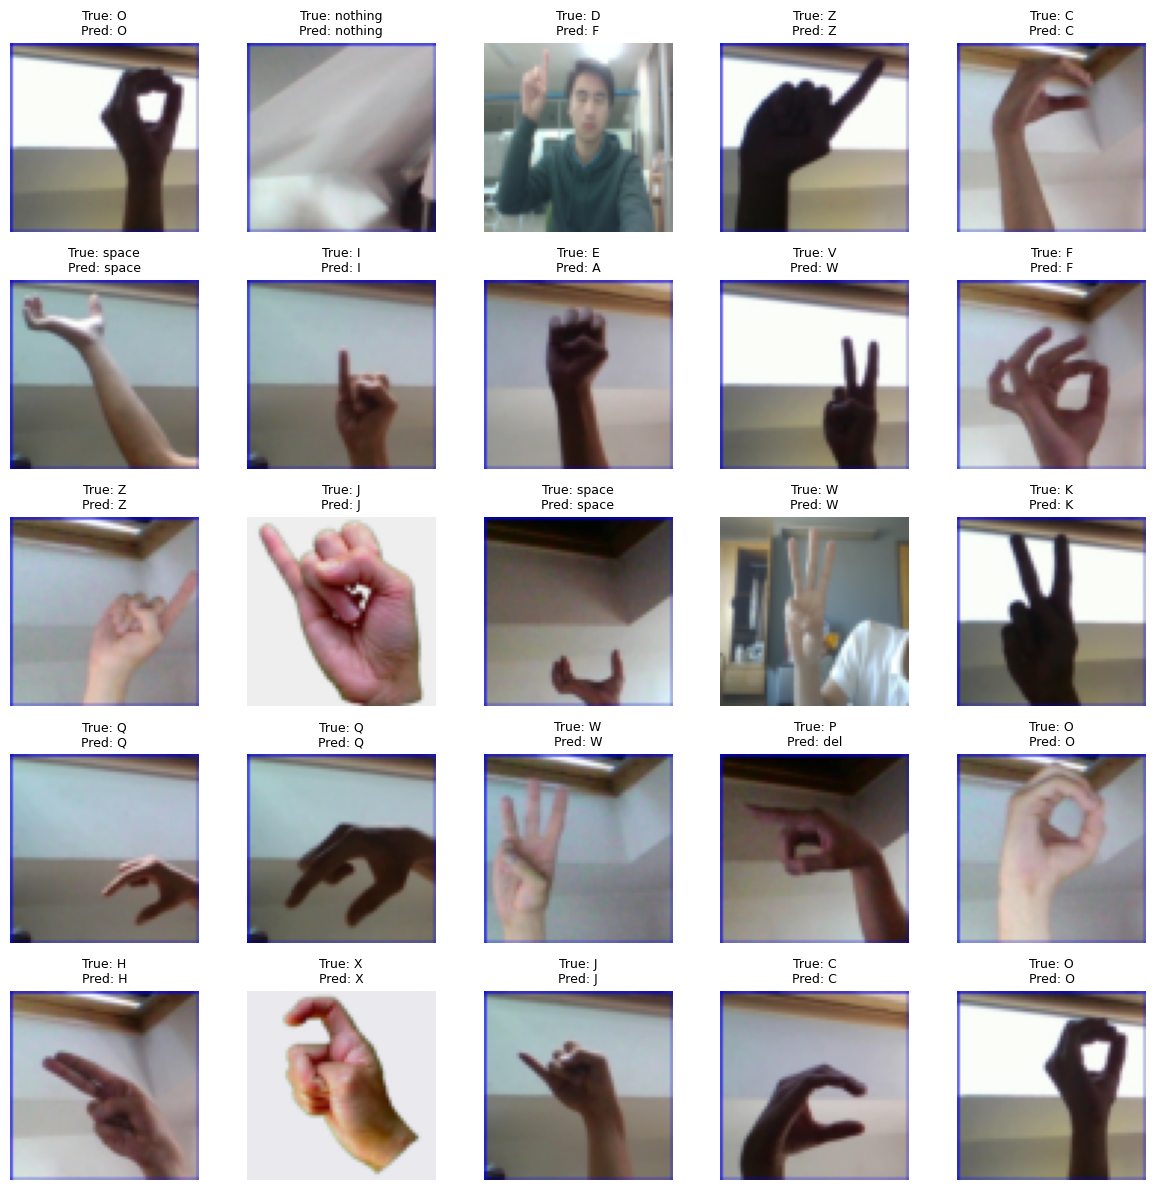

In [ ]:
# --- Mostrar un grid de imágenes del test set ---
def show_predictions_grid(model, dataloader, num_images=25):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, 12))

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                plt.subplot(5, 5, images_shown + 1)  # 5x5 grid
                plot_image(images[i], labels[i].item(), preds[i].item())
                images_shown += 1

# --- Llamar función ---
show_predictions_grid(model, test_loader, num_images=25)

In [ ]:
import torch

model.eval()  # Modo evaluación
test_loss = 0.0
correct = 0
total = 0

criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total

print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")


Test Loss: 0.6271 | Test Accuracy: 82.20%


In [ ]:
!pip install tensorflowjs

import tensorflow as tf
import json, os

model.save("asl_model.h5")

class_names = train_ds.class_names
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

!tensorflowjs_converter --input_format=keras asl_model.h5 ./tfjs_model


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.35.1 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.8.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.


NameError: name 'model' is not defined